In [14]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans 
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
import warnings
warnings.filterwarnings("ignore")
import copy
import pdb

In [15]:
def load_data(path):

    data = pd.read_csv(path, delimiter=',')
    data = data.values
    X = data[:, :-1]
    y = data[:,-1]
    return X,y

In [16]:
def cat2num(y):
    for i in range(len(y)):
        if y[i] == 'dos':
            y[i] = 0
        elif y[i] == 'normal':
            y[i] = 1
        elif y[i] == 'probe':
            y[i] = 2
        elif y[i] == 'r2l':
            y[i] = 3
        else:
            y[i] = 4
    return y

In [23]:
 def activation(z, derivative=False, type=None):
        # Sigmoid activation function
        if type == "sigmoid":
            if derivative:
                return activation(z, type="sigmoid") * (1 - activation(z, type="sigmoid"))
            else:
                return 1 / (1 + np.exp(-z))
        
        # ReLu activation function    
        if type == "relu":
            if derivative:
                z[z <= 0.0] = 0.
                z[z > 0.0] = 1.
                return z
            else:
                return np.maximum(0, z)
        
        # Tanh activation function
        if type == "tanh":
            if derivative:
                return activation(z, type="tanh") * (1 - activation(z, type="tanh"))
            else:
                return np.tanh(z)


In [18]:
def autoencoder(X,y,hidden_layer,lr,epoch,act_fn):
    # np.random.seed(42)

    print('\nAutoencoder Running ! \n')

    W1 = np.random.randn(X.shape[1],hidden_layer)
    W2 = W1.T

    losses = []

    for e in range(epoch):

        #-----------------------Forward--------------------------

        z1 = np.dot(X,W1)
        a1 = activation(z1,type = act_fn)
        z2 = np.dot(a1,W2)
        a2 = activation(z2,type = act_fn)
        loss = np.sum(np.power((a2-y),2))/len(y)

        #--------------------Backpropagate-----------------------

        dW2 = np.dot(a1.T,2*(a2-y)*activation(z2,derivative = True,type = act_fn))
        delta = np.dot(2*(a2-y)*activation(z2,derivative = True,type = act_fn),W2.T)*activation(z1,derivative = True,type = act_fn)
        dW1 = np.dot(X.T,delta)

        #--------------------Weight Update------------------------

        W2 = W2 - (lr*dW2)
        W1 = W1 - (lr*dW1)

        losses.append(loss)

        print("Epoch : {}/{}".format(e+1, epoch), end='\r')

    plt.figure(1)
    plt.plot(range(epoch),losses)
    plt.xlabel("Epochs")
    plt.ylabel("MSE Loss")
    plt.title('Plot of Loss vs Epoch to verify correct functioning of NN for {} Epochs'.format(epoch))
    print('Data reduced to new dimention {}\n'.format(hidden_layer))
    return z1

In [19]:
def dist(a, b):
    return np.linalg.norm(a - b, axis=1)

In [29]:
def kmeans_clustering(x_reduced,k,D):
    
    centroid= np.random.randint(0, np.max(x_reduced), size=k)
    centroid = centroid.reshape(k,1)
    for i in range (1,x_reduced.shape[1]):    
        centroid_i = np.random.randint(0, np.max(x_reduced), size=k)  #Generate random values between 0 and max(x)-20 of k dimention
        centroid_i = centroid_i.reshape(k,1)
        centroid = np.hstack((centroid,centroid_i))
        
    print("Clustering Started !!!")
    print('')
    print("Initial Centroids Set to:")
    print(centroid)
    print('')

    centroid_old = np.zeros(centroid.shape)
    clusters = np.zeros(len(x_reduced))
    error_dist = dist(centroid, centroid_old)    

    while np.count_nonzero(error_dist) != 0:  #Iterate until there is no change in centroid position
        
        for i in range(len(x_reduced)):  # Labelling each point w.r.t its nearest cluster
            distances = dist(x_reduced[i], centroid)
            cluster = np.argmin(distances)
            clusters[i] = cluster
        
        centroid_old = copy.deepcopy(centroid)
        for i in range(k): #New centroid will be the average of the distances
            points = [x_reduced[j] for j in range(len(x_reduced)) if clusters[j] == i]  #All the points which are under ith cluster as per current clustering
            centroid[i] = np.mean(points, axis=0)
        error_dist = dist(centroid, centroid_old)
        print('Distance moved by Centroids in next interation')
        print(error_dist)
        print('')
    print('Clustering Completed !!!')
    print('')

    if D == 0: 
        plt.figure(2)
        color=['cyan','magenta','red','blue','green']
        labels=['cluster1','cluster2','cluster3','cluster4','cluster5']
        for i in range(k):
            points = np.array([x_reduced[j] for j in range(len(x_reduced)) if clusters[j] == i])
            print('No. of points in Cluster {} : {} '.format(i,points.shape))
            if points.size != 0:
                plt.scatter(points[:,0],points[:,1],c=color[i],label=labels[i])
    #     plt.scatter(centroid[:,0],centroid[:,1],s=300,c='y',label='Centroids')
        plt.title('Clusters of Network Attack after reducing data to 2-D using PCA')
        plt.xlabel('Attribte 1')
        plt.ylabel('Attribute 2')
        plt.legend()
        plt.show()
    return clusters

In [30]:
def cal_purity(labels,y):
    cnf_matrix = np.zeros((5,5))
    for i in range(len(y)):
                cnf_matrix[int(labels[i]),y[i]] +=1 
    num = 0
    for i in range(5):
        num += np.max(cnf_matrix[i]) 
    return (num/len(y))

Hyperparameters set to:

    Nuerons in Hidden Layer: 14
    Learning Rate: 0.001
    Number of Epochs: 100
    Activation Function: sigmoid


Autoencoder Running ! 

Data reduced to new dimention 14


Doing Clustering by selecting reduced number of dimentions in PCA as per threshold of 10%

Clustering Started !!!

Initial Centroids Set to:
[[ 24  36 137 217 144  16 133  78 213 188  92  39 111  32]
 [126 228  35  98 122 190  42  74 171  38 204 175 136 137]
 [ 38 245 216 191 167 140  46  87 232 102  73 182 125  17]
 [  3 224  51 243 143 219 200 112 237 154  48  34  92 150]
 [ 26 132  92  64 186 142 128  38  93 209  77 242  46 200]]

Distance moved by Centroids in next interation
[4.65336437e+02 8.03514758e+09 8.03514756e+09 8.03514754e+09
 6.41783453e+02]

Distance moved by Centroids in next interation
[  0.           0.           0.           0.         140.52757736]

Distance moved by Centroids in next interation
[ 0.          0.          0.          0.         63.16644679]

Distance 

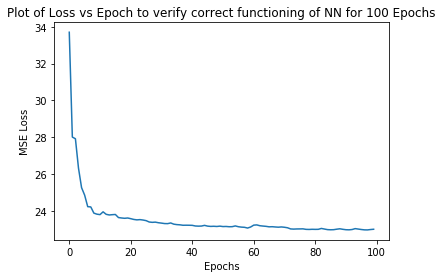

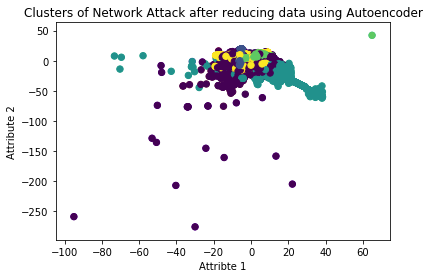

In [35]:
if __name__ == "__main__":
    
    np.random.seed(26)
    path = '../Dataset/intrusion_detection/data.csv'
    X,y_true = load_data(path)
    y_true = cat2num(y_true)
    X = StandardScaler().fit_transform(X)
    y = copy.deepcopy(X)
    
    #--------------------------------Hyperparameters------------------------------------------------------
    hidden_layer = 14
    lr = 0.001
    epoch = 100
    act_fn = 'sigmoid'
    print('Hyperparameters set to:\n\n    Nuerons in Hidden Layer: {}\n    Learning Rate: {}\n    Number of Epochs: {}\n    Activation Function: {}\n'.format(hidden_layer,lr,epoch,act_fn))
    print('===============================================================================================')
    
    #------------------------------------Autoencoder------------------------------------------------------
    x_reduced = autoencoder(X,y,hidden_layer,lr,epoch,act_fn)
    print('===============================================================================================')
    
    #-----------------------------------------KMeans------------------------------------------------------
    print('\nDoing Clustering by selecting reduced number of dimentions in PCA as per threshold of 10%\n')
    clusters1 = kmeans_clustering(x_reduced,5,1)
    purity1 = cal_purity(clusters1,y_true)
    print('===============================================================================================')
    print('\nPurity while using own developed KMeans:{}\n '.format(purity1))

    kmeans = KMeans(n_clusters=5)  
    kmeans.fit(x_reduced)  
    clusters2 = kmeans.labels_
    purity2 = cal_purity(clusters2,y_true)
    print('Purity while using KMeans from Sci-Kit Learn:{}\n '.format(purity2))
    
    plt.figure(2)
    plt.scatter(x_reduced[:,0],x_reduced[:,1], c=kmeans.labels_, cmap='rainbow')
    plt.scatter(kmeans.cluster_centers_[:,0] ,kmeans.cluster_centers_[:,1], color='black')
    plt.title('Clusters of Network Attack after reducing data using Autoencoder')
    plt.xlabel('Attribte 1')
    plt.ylabel('Attribute 2')
    
    print('===============================================================================================')
    #-----------------------------------------GMM------------------------------------------------------------
    print('\nGMM Started !!!\n')
    gmm = GaussianMixture(n_components=5).fit(x_reduced)
    labels = gmm.predict(x_reduced)
    plt.scatter(x_reduced[:, 0], x_reduced[:, 1], c=labels, s=40, cmap='viridis');
    print('GMM Completed !!!\n')
    
    purity_gmm = cal_purity(labels,y_true)
    print('Purity while using GMM: ', purity_gmm)
    print('\n===============================================================================================')
    
    plt.show()

In [ ]:
#     Hierarchical clustering
print('\nHierarchical clustering Started !!!')
clustering = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='single')
clustering.fit_predict(x_reduced)
labels = clustering.labels_
plt.scatter(x_reduced[:, 0], x_reduced[:, 1], c=labels, s=40, cmap='viridis');
print('Hierarchical clustering Completed !!!')
print('')
purity_hc = cal_purity(labels,y_true)
print('Purity while using HIerarchical Clustering: ', purity_hc)
print('\n===============================================================================================')